In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from scipy.io import loadmat,savemat
from scipy.interpolate import interp1d
from pyDOE import lhs
from IPython.display import clear_output
from torch.distributions import MultivariateNormal
import json
import copy

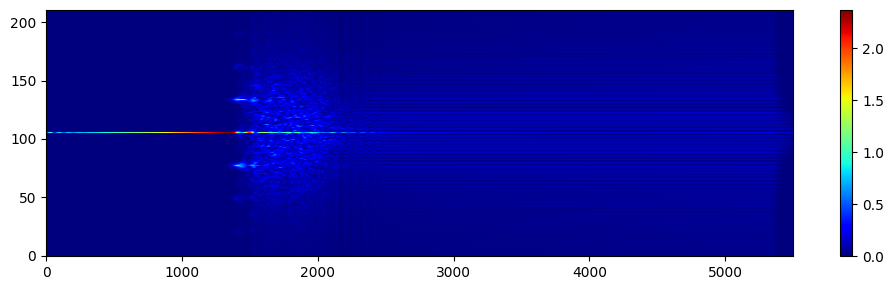

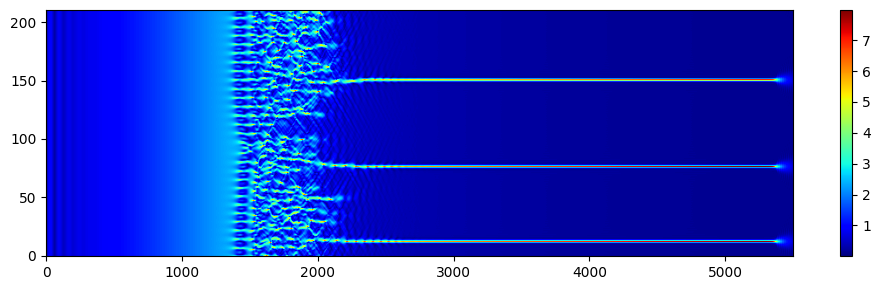

In [2]:
data = loadmat('A.mat')['A']
data.shape

# %%
plt.figure(figsize=(10, 3))
plt.imshow(np.abs(data), cmap='jet', origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()

data_ifft = np.fft.fft(data, axis=0)
plt.figure(figsize=(10, 3))
plt.imshow(np.abs(data_ifft), cmap='jet', origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()
plt.close()

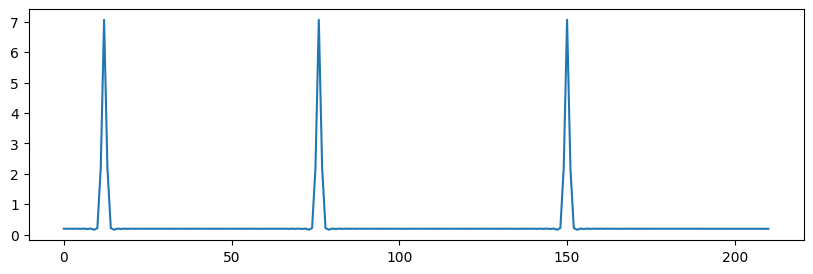

In [3]:
# plot the 4000 index of data_ifft abs
plt.figure(figsize=(10, 3))
plt.plot(np.abs(data_ifft[:, 4000]))
plt.show()

In [4]:
zeta = np.linspace(-10,45,5500)
# find the 4000 index
zeta[4000]

np.float64(30.007274049827245)

In [2]:
class MRR:
  def __init__(self, params):
    self.N = params['N']
    self.n0 = params['n0']
    self.n2 = params['n2']
    self.FSR = params['FSR']
    self.lambda_0 = params['lambda_0']
    self.Veff = params['Veff']
    self.D2 = params['D2']
    self.Pin = params['Pin']
    self.kappa = 2*np.pi*params['kappa']
    self.eta = params['eta']
    self.dseta_start = params['dseta_start']
    self.dseta_stop = params['dseta_stop']
    self.dseta_step = params['dseta_step']
    self.num_round_trips = 1 #number of roundtrips per tuning step
    self.R = 23e-6
    # self.num_steady_state_rt = 25000
    self.modes = np.arange(-(self.N - 1) / 2, ((self.N - 1) / 2) + 1, 1)


    self.Tr = 1/self.FSR
    self.f0 = cts.c/self.lambda_0
    self.omega_0 = 2*np.pi*self.f0
    self.g = self.g = cts.hbar * self.omega_0**2 * cts.c * self.n2 / (self.n0**2 * self.Veff) # Nonlinear coupling coefficient

    self.f_amp = np.sqrt((8 * self.g * self.eta / self.kappa**2) * (self.Pin / (cts.hbar * self.omega_0)))
    self.d2 = (1/self.kappa)*2*np.pi*self.D2
    self.mu = np.arange(-(self.N - 1) / 2, ((self.N - 1) / 2) + 1, 1) # Mode numbers relative to the pumped mode
    self.dint = (self.d2 / 2) * self.mu**2 # Normalized integrated dispersion

    self.seta = np.arange(self.dseta_start, self.dseta_stop, self.dseta_step)[:,np.newaxis]
    # self.seta = 24*np.ones_like(self.seta)
    self.del_omega = self.seta*self.kappa/2
    self.seta_array = np.repeat(self.seta, self.N, axis=1).T

    self.omega_mu = self.omega_0 + 2*np.pi*self.FSR*self.mu + np.pi*self.D2*self.mu**2


  def calc_beta2(self):
    f_center = self.f0
    mode_numbers = np.arange(-(self.N - 1) / 2, ((self.N - 1) / 2) + 1, 1)

    L = 2*np.pi*self.R
    self.freq_array = f_center + mode_numbers * self.FSR
    ng_estimated = cts.c / (L * np.gradient(self.freq_array))


    self.D_int = (self.D2/2)*(self.modes)**2 + 1e-6
    # # Calculate beta_2 as a function of frequency
    D1 = 2 * np.pi * self.FSR  # D1 in rad/s
    # beta_2 = -(self.n0* 2*np.pi*self.D2) / (cts.c * (2*np.pi*self.FSR)**2)
    # self.beta_2_array = beta_2_array

    # LD = self.Tr**2/np.abs(beta_2)# dispersion length
    theta_norm = np.sqrt(1/(2*self.d2))#np.sqrt((self.kappa/(2*np.pi))/(2*self.D2))
    self.theta = (np.linspace(-np.pi, np.pi, self.N) + D1*np.linspace(0, len(self.seta)*self.Tr, self.N))*theta_norm # normalized frequency detuning
    self.tau = 0.5*self.kappa*np.linspace(0, len(self.seta)*self.Tr, len(self.seta)) # normalized time coordinate tau = kappa*t/2
    

  def find_Nmax(self):
    D2 = 2*np.pi*self.D2
    self.N_max = np.floor(np.sqrt(self.kappa/D2))
    # return a random integer between 1 and N_max
    return np.random.randint(1, self.N_max)

  def gen_Psi_init(self):
    psi_0 = self.f_amp/self.seta[0]**2 - 1j*self.f_amp/self.seta[0]
    B = np.sqrt(2*self.seta[0])
    phi_0 = np.arccos(np.sqrt(8*self.seta[0])/(np.pi*self.f_amp))
    C2 = 4*self.seta[0]/(np.pi*self.f_amp) + 1j*np.sqrt( 2*self.seta[0] - 16*self.seta[0]**2/((np.pi*self.f_amp)**2) )
    self.soliton_spacing = np.ceil((8/B)*np.sqrt(2*self.d2))
    N = self.find_Nmax()
    solitons = 0
    phi_ = np.linspace(-np.pi,np.pi,self.N)
    for ii in range(N):
      phi_j = np.roll(phi_, int(self.soliton_spacing*ii))
      solitons += 1/( np.cosh( np.sqrt(self.seta[0]/self.d2) * (phi_-phi_j) ) )
    psi_init = psi_0 + C2*solitons
    return psi_init


  def gen_tau_t(self, N0=100, Nb=100, Nf=20000):

    # initial condition
    t_0 = self.tau.min()
    theta_0 = self.theta
    T0, Theta0 = np.meshgrid(t_0, theta_0)
    T0 = T0.flatten()[:, np.newaxis]
    Theta0 = Theta0.flatten()[:, np.newaxis]
    idx = np.random.choice(len(T0), N0, replace=False)
    idx = np.sort(idx)
    T0 = T0[idx]
    Theta0 = Theta0[idx]
    # u_init = np.real(data_ifft[idx,1:2])
    # v_init = np.imag(data_ifft[idx,1:2])

    psi_init = np.fft.ifft(np.sqrt(2*self.g/self.kappa)*(np.random.randn(len(T0)) + 1j*np.random.randn(len(T0))))
    u_init = np.real(psi_init)[:,np.newaxis]
    v_init = np.imag(psi_init)[:,np.newaxis]

    # u_init = u_init[idx]#[:,np.newaxis]
    # v_init = v_init[idx]#[:,np.newaxis]

    # boundary conditions
    Tb = self.tau
    theta_lb = self.theta.min()
    theta_ub = self.theta.max()

    T_lb, Theta_lb = np.meshgrid(Tb, theta_lb)
    T_ub, Theta_ub = np.meshgrid(Tb, theta_ub)

    T_lb = T_lb.flatten()[:, np.newaxis]
    Theta_lb = Theta_lb.flatten()[:, np.newaxis]
    T_ub = T_ub.flatten()[:, np.newaxis]
    Theta_ub = Theta_ub.flatten()[:, np.newaxis]

    idx = np.random.choice(len(T_lb), Nb, replace=False)
    idx = np.sort(idx)
    T_lb = T_lb[idx]
    Theta_lb = Theta_lb[idx]
    T_ub = T_ub[idx]
    Theta_ub = Theta_ub[idx]

    T,Theta = np.meshgrid(self.tau, self.theta)
    print('T shape:', T.shape)
    print('Theta shape:', Theta.shape)
    T = T.flatten()[:, np.newaxis]
    Theta = Theta.flatten()[:, np.newaxis]
    idx = np.random.choice(len(T), Nf, replace=False)
    idx = np.sort(idx)
    T = T[idx]
    Theta = Theta[idx]

    F =  self.f_amp*np.ones_like(T)#self.f_mat.flatten()[:,np.newaxis][idx]#np.sqrt((8*self.g*self.eta/self.kappa**2)*(self.Pin/(cts.hbar*self.omega_0)))*np.ones_like(T)
    seta_array = self.seta_array.flatten()[:, np.newaxis][idx]
    return T0, Theta0, u_init, v_init, T_lb, Theta_lb, T_ub, Theta_ub, T, Theta, seta_array, F

  def gen_tau_t_lhs(self, N0=100, Nb=100, Nf=20000):

    t_0 = self.tau.min()
    theta_0 = self.theta

    T0, Theta0 = np.meshgrid(t_0, theta_0)
    T0 = T0.flatten()[:, np.newaxis]
    Theta0 = Theta0.flatten()[:, np.newaxis]

    # Random selection for initial condition
    idx = np.random.choice(len(T0), N0, replace=False)
    idx = np.sort(idx)
    T0 = T0[idx]
    Theta0 = Theta0[idx]

    # u_init = np.real(data_ifft[idx, 1:2])
    # v_init = np.imag(data_ifft[idx, 1:2])

    psi_init = np.sqrt(2*self.g/self.kappa)*(np.random.rand(len(Theta0)) + 1j*np.random.rand(len(Theta0)))
    u_init = np.real(psi_init)[:,np.newaxis]
    v_init = np.real(psi_init)[:,np.newaxis]

    # boundary conditions
    Tb = self.tau
    theta_lb = self.theta.min()
    theta_ub = self.theta.max()

    T_lb, Theta_lb = np.meshgrid(Tb, theta_lb)
    T_ub, Theta_ub = np.meshgrid(Tb, theta_ub)

    T_lb = T_lb.flatten()[:, np.newaxis]
    Theta_lb = Theta_lb.flatten()[:, np.newaxis]
    T_ub = T_ub.flatten()[:, np.newaxis]
    Theta_ub = Theta_ub.flatten()[:, np.newaxis]

    idx = np.random.choice(len(T_lb), Nb, replace=False)
    idx = np.sort(idx)
    T_lb = T_lb[idx]
    Theta_lb = Theta_lb[idx]
    T_ub = T_ub[idx]
    Theta_ub = Theta_ub[idx]

    # Use LHS for sampling collocation points from the meshgrid
    T, Theta = np.meshgrid(self.tau, self.theta)
    T = T.flatten()[:, np.newaxis]
    Theta = Theta.flatten()[:, np.newaxis]

    # LHS sampling over the meshgrid
    lhs_samples = lhs(2, samples=Nf)  # 2 dimensions for T and Theta

    # Rescale LHS samples to match the range of the meshgrid for T and Theta
    T_sampled = np.min(T) + (np.max(T) - np.min(T)) * lhs_samples[:, 0][:, np.newaxis]
    Theta_sampled = np.min(Theta) + (np.max(Theta) - np.min(Theta)) * lhs_samples[:, 1][:, np.newaxis]

    # F and seta_array for sampled collocation points
    F = self.f_amp * np.ones_like(T_sampled)
    # seta_array = self.seta_array.flatten()[:, np.newaxis][:Nf]
    # Sample seta_array in the same manner
    seta_array_flat = self.seta_array.flatten()[:, np.newaxis]
    seta_array = np.min(seta_array_flat) + (np.max(seta_array_flat) - np.min(seta_array_flat)) * lhs_samples[:, 0][:, np.newaxis]

    return T0, Theta0, u_init, v_init, T_lb, Theta_lb, T_ub, Theta_ub, T_sampled, Theta_sampled, seta_array, F
  
  def gen_tau_t_time_march(self, N0=100, Nb=100, Nf=20000, M=5):
    # Dictionary to store data for each time marching step
    time_marching_data = {}

    # If tau is not provided, use the min value of tau as the starting point
    tau = self.tau
    theta = self.theta
    seta_array_flat = self.seta.flatten()[:, np.newaxis]

    # Split tau and seta_array into M parts
    tau_splits = np.array_split(tau, M)
    seta_splits = np.array_split(seta_array_flat, M)  # Split seta_array in the same manner as tau

    # Create the array of boundary points for time marching
    T_marching_boundaries = []
    T_marching_boundaries.append(tau_splits[0][0])  # First element of the first split
    for split in tau_splits:
        T_marching_boundaries.append(split[-1])  # Last element of each split

    # Iterate over each marching step (between successive elements of T_marching_boundaries)
    for i in range(M):
        print(f'Generating data for time marching step {i + 1}/{M}')
        t_min = T_marching_boundaries[i]
        t_max = T_marching_boundaries[i + 1]
        t_0 = t_min  # Define t_0 as the time range for this step
        theta_0 = theta

        # Generate initial condition meshgrid for this time step
        T0, Theta0 = np.meshgrid(t_0, theta_0)
        T0 = T0.flatten()[:, np.newaxis]
        Theta0 = Theta0.flatten()[:, np.newaxis]

        # Random selection for initial condition
        idx = np.random.choice(len(T0), N0, replace=False)
        idx = np.sort(idx)
        T0 = T0[idx]
        Theta0 = Theta0[idx]

        if i == 0:
            # u_init = np.real(data_ifft[idx, 1:2])
            # v_init = np.imag(data_ifft[idx, 1:2])
            psi_init = np.sqrt(2*self.g/self.kappa)*(np.random.rand(len(Theta0)) + 1j*np.random.rand(len(Theta0)))
            u_init = np.real(psi_init)[:,np.newaxis]
            v_init = np.real(psi_init)[:,np.newaxis]
        else:
            u_init = np.zeros_like(T0)
            v_init = np.zeros_like(T0)

        # Boundary conditions
        Tb = np.linspace(t_min, t_max, len(tau))  # Time for the boundary conditions
        theta_lb = self.theta.min()
        theta_ub = self.theta.max()

        T_lb, Theta_lb = np.meshgrid(Tb, theta_lb)
        T_ub, Theta_ub = np.meshgrid(Tb, theta_ub)

        T_lb = T_lb.flatten()[:, np.newaxis]
        Theta_lb = Theta_lb.flatten()[:, np.newaxis]
        T_ub = T_ub.flatten()[:, np.newaxis]
        Theta_ub = Theta_ub.flatten()[:, np.newaxis]

        idx = np.random.choice(len(T_lb), Nb, replace=False)
        idx = np.sort(idx)
        T_lb = T_lb[idx]
        Theta_lb = Theta_lb[idx]
        T_ub = T_ub[idx]
        Theta_ub = Theta_ub[idx]

        T, Theta = np.meshgrid(np.linspace(t_min, t_max, len(tau)), self.theta)
        T = T.flatten()[:, np.newaxis]
        Theta = Theta.flatten()[:, np.newaxis]
        idx = np.random.choice(len(T), Nf, replace=False)
        idx = np.sort(idx)
        T_sampled = T[idx]
        Theta_sampled = Theta[idx]
        seta_array = np.repeat(np.linspace(np.min(seta_splits[i]), np.max(seta_splits[i]), len(tau))[:,np.newaxis], len(self.theta), axis=1).T
        seta_array = seta_array.flatten()[:, np.newaxis][idx]
        F = self.f_amp * np.ones_like(T_sampled)

        # Store the data for the current split in the dictionary
        time_marching_data[i] = {
            'T0': T0,
            'Theta0': Theta0,
            'u_init': u_init,
            'v_init': v_init,
            'T_lb': T_lb,
            'Theta_lb': Theta_lb,
            'T_ub': T_ub,
            'Theta_ub': Theta_ub,
            'T_sampled': T_sampled,
            'Theta_sampled': Theta_sampled,
            'seta_array': seta_array,
            'F': F
        }

    # Return the dictionary with data for each time split
    return time_marching_data

  def gen_tau_t_lhs_time_march(self, N0=100, Nb=100, Nf=20000, M=5):
    # Dictionary to store data for each time marching step
    time_marching_data = {}

    # If tau is not provided, use the min value of tau as the starting point
    tau = self.tau
    theta = self.theta
    seta_array_flat = self.seta.flatten()[:, np.newaxis]

    # Split tau and seta_array into M parts
    tau_splits = np.array_split(tau, M)
    seta_splits = np.array_split(seta_array_flat, M)  # Split seta_array in the same manner as tau

    # Create the array of boundary points for time marching
    T_marching_boundaries = []
    T_marching_boundaries.append(tau_splits[0][0])  # First element of the first split
    for split in tau_splits:
        T_marching_boundaries.append(split[-1])  # Last element of each split

    # Iterate over each marching step (between successive elements of T_marching_boundaries)
    for i in range(M):
        print(f'Generating data for time marching step {i + 1}/{M}')
        t_min = T_marching_boundaries[i]
        t_max = T_marching_boundaries[i + 1]
        t_0 = t_min  # Define t_0 as the time range for this step
        theta_0 = theta

        # Generate initial condition meshgrid for this time step
        T0, Theta0 = np.meshgrid(t_0, theta_0)
        T0 = T0.flatten()[:, np.newaxis]
        Theta0 = Theta0.flatten()[:, np.newaxis]

        # Random selection for initial condition
        idx = np.random.choice(len(T0), N0, replace=False)
        idx = np.sort(idx)
        T0 = T0[idx]
        Theta0 = Theta0[idx]

        if i == 0:
            # u_init = np.real(data_ifft[idx, 1:2])
            # v_init = np.imag(data_ifft[idx, 1:2])
            psi_init = np.sqrt(2*self.g/self.kappa)*(np.random.rand(len(Theta0)) + 1j*np.random.rand(len(Theta0)))
            u_init = np.real(psi_init)[:,np.newaxis]
            v_init = np.real(psi_init)[:,np.newaxis]
        else:
            u_init = np.zeros_like(T0)
            v_init = np.zeros_like(T0)

        # Boundary conditions
        Tb = np.linspace(t_min, t_max, len(tau))  # Time for the boundary conditions
        theta_lb = self.theta.min()
        theta_ub = self.theta.max()

        T_lb, Theta_lb = np.meshgrid(Tb, theta_lb)
        T_ub, Theta_ub = np.meshgrid(Tb, theta_ub)

        T_lb = T_lb.flatten()[:, np.newaxis]
        Theta_lb = Theta_lb.flatten()[:, np.newaxis]
        T_ub = T_ub.flatten()[:, np.newaxis]
        Theta_ub = Theta_ub.flatten()[:, np.newaxis]

        idx = np.random.choice(len(T_lb), Nb, replace=False)
        idx = np.sort(idx)
        T_lb = T_lb[idx]
        Theta_lb = Theta_lb[idx]
        T_ub = T_ub[idx]
        Theta_ub = Theta_ub[idx]

        # Use LHS for sampling collocation points from the meshgrid
        T, Theta = np.meshgrid(np.linspace(t_min, t_max, len(tau)), self.theta)
        T = T.flatten()[:, np.newaxis]
        Theta = Theta.flatten()[:, np.newaxis]

        # LHS sampling over the meshgrid
        lhs_samples = lhs(2, samples=Nf)  # 2 dimensions for T and Theta

        # Rescale LHS samples to match the range of the meshgrid for T and Theta
        T_sampled = np.min(T) + (np.max(T) - np.min(T)) * lhs_samples[:, 0][:, np.newaxis]
        Theta_sampled = np.min(Theta) + (np.max(Theta) - np.min(Theta)) * lhs_samples[:, 1][:, np.newaxis]

        # F and seta_array for sampled collocation points
        F = self.f_amp * np.ones_like(T_sampled)

        # For each time marching step, use the corresponding split of seta_array
        seta_array = np.min(seta_splits[i]) + (np.max(seta_splits[i]) - np.min(seta_splits[i])) * lhs_samples[:, 0][:, np.newaxis]

        # Store the data for the current split in the dictionary
        time_marching_data[i] = {
            'T0': T0,
            'Theta0': Theta0,
            'u_init': u_init,
            'v_init': v_init,
            'T_lb': T_lb,
            'Theta_lb': Theta_lb,
            'T_ub': T_ub,
            'Theta_ub': Theta_ub,
            'T_sampled': T_sampled,
            'Theta_sampled': Theta_sampled,
            'seta_array': seta_array,
            'F': F
        }

    # Return the dictionary with data for each time split
    return time_marching_data


In [3]:
class RandomWeightFactorizationLayer(nn.Module):
  def __init__(self, in_features, out_features, mu=0.5, sigma=0.1):
    super(RandomWeightFactorizationLayer, self).__init__()

    # Step 1: Glorot initialization (Xavier initialization) for V
    V = torch.empty(out_features, in_features)
    nn.init.xavier_normal_(V)
    self.V = nn.Parameter(self.V)

    # Step 2: Initialize s from a normal distribution N(mu, sigma)
    self.s = nn.Parameter(torch.randn(out_features) * sigma + mu)

    self.bias = nn.Parameter(torch.randn(out_features))

  def forward(self, x):
    # Apply random weight factorization: W = diag(exp(s)) @ V
    W = torch.diag(torch.exp(self.s)) @ self.V  # Apply the factorization
    return torch.matmul(x, W.t()) + self.bias

class FourierFeatureEmbedding(nn.Module):
  def __init__(self, mapping_size, scales=[5.0], P_x=1, P_t=1):
    super(FourierFeatureEmbedding, self).__init__()
    # clip scale between 1,10
    # scale = max(1, min(10, scale))

    # Detect the available device (GPU if available, otherwise CPU)
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.P_x = P_x
    self.P_t = P_t

    scale_1 = scales[0]*np.ones(len(scales))
    # Random matrix for projecting inputs to Fourier feature space, placed on the correct device
    # Instead of directly creating tensors, register them as buffers
    self.register_buffer('B_t', torch.cat([scale * torch.randn((1, mapping_size), device=self.device) for scale in scale_1], dim=1))
    self.register_buffer('B_x', torch.cat([scale * torch.randn((1, mapping_size), device=self.device) for scale in scales], dim=1))

  def forward(self, x):
    # Ensure input is on the same device as the random matrix
    x = x.to(self.device)

    t_proj = (2 * torch.pi * x[:, 0:1] / self.P_t) @ self.B_t
    x_proj = (2 * torch.pi * x[:, 1:2] / self.P_x) @ self.B_x

    # Project input using Fourier features
    # f_proj = torch.cat([torch.sin(t_proj), torch.cos(t_proj), torch.sin(x_proj), torch.cos(x_proj)], dim=1)

    return torch.cat([torch.cos(t_proj), torch.sin(t_proj)],dim=1), torch.cat([torch.cos(x_proj), torch.sin(x_proj)], dim=1)

class PINN(nn.Module):
  def __init__(self, layers, mapping_size=64, scale=[10.0], use_fourier_features=True, use_rwf=False, P_x=1, P_t=1, mu=1.0, sigma=0.1):
    super(PINN, self).__init__()

    input_dim = layers[0]
    layers = layers[1:]
    self.use_rwf = use_rwf
    self.use_fourier_features = use_fourier_features
    self.mapping_size = mapping_size
    self.scale = scale

    # Fourier Feature Embedding
    if use_fourier_features:
      self.fourier_embedding = FourierFeatureEmbedding(mapping_size, scale, P_x, P_t)
      modified_layers = [4 * mapping_size*len(scale)] + layers[1:]
    else:
      modified_layers = layers

    print('Modified Layers: ',modified_layers)

    # Create layers with either regular Linear or RWF layers
    self.layers = nn.ModuleList()
    for i in range(len(modified_layers) - 1):
      if use_rwf:
        # if i==len(modified_layers)-2:
        #   self.layers.append(RandomWeightFactorizationLayer(2*modified_layers[i], modified_layers[i + 1], mu=mu, sigma=sigma))
        # else:
        self.layers.append(RandomWeightFactorizationLayer(modified_layers[i], modified_layers[i + 1], mu=mu, sigma=sigma))
      else:
        self.layers.append(nn.Linear(modified_layers[i], modified_layers[i + 1]))

    self.activation = nn.Tanh()

  def forward(self, x):
    # Apply Fourier feature embedding if selected
    if self.use_fourier_features:
      t_f,x_f = self.fourier_embedding(x)

    t_x_f = torch.cat([t_f, x_f], dim=1)

    # Pass through the network layers with activations
    for i in range(len(self.layers) - 1):
      # t_f = self.activation(self.layers[i](t_f))
      t_x_f = self.activation(self.layers[i](t_x_f))

    # x = torch.multiply(t_f,x_f)#torch.cat([t_f,x_f],dim=1)
    # Output layer (no activation)
    x = self.layers[-1](t_x_f)
    return x

def causal_aware_loss2(residual_losses, unique, inverse_indices, epsilon):
    """
    Computes the causal-aware weighted residual loss using PyTorch in a vectorized manner.

    Args:
        residual_losses (torch.Tensor): Residual losses at each time step t_i. Should be a 1D tensor of size N_t.
        unique (torch.Tensor): Unique time steps (sorted).
        inverse_indices (torch.Tensor): Indices mapping each residual_loss to its corresponding unique timestep.
        epsilon (float): Causality parameter that controls the steepness of the weights w_i.

    Returns:
        torch.Tensor: The causal-aware weighted residual loss L_r(theta).
        bool: True if the stopping condition is met, False otherwise.
        np.ndarray: The weights w_i.
        torch.Tensor: The L2 norm of the weighted residual losses.
    """
    # Sum residual losses for each unique timestep using scatter_add
    loss_t = torch.zeros(unique.size(0), dtype=residual_losses.dtype, device=residual_losses.device)
    
    # Unsqueeze inverse_indices to match the dimensions of loss_t if necessary
    inverse_indices = inverse_indices.view(-1)  # Ensure inverse_indices is 1D
    residual_losses = residual_losses.view(-1)  # Ensure residual_losses is 1D

    loss_t.scatter_add_(0, inverse_indices, residual_losses)

    # Calculate cumulative sum of losses (without the current element for each index)
    with torch.no_grad():
        loss_cumsum = torch.cumsum(loss_t, dim=0) - loss_t
        w_i = torch.exp(-epsilon * loss_cumsum)
    
    # Compute the final loss
    loss_mod = torch.mean(w_i * loss_t)
    norm_pde = torch.norm(w_i * loss_t, p=2)
    
    # Check stopping condition (if all w_i are > 0.99)
    break_ = torch.min(w_i) > 0.99
    break_ = break_.cpu().detach().numpy()

    return loss_mod, break_, w_i.cpu().numpy(), norm_pde

def lle_loss(model, T0, Theta0, u_init, v_init, T_lb, Theta_lb, T_ub, Theta_ub, T, Theta, seta_array, F, cal=False, epsilon=100):
  # define initial condition loss
  e_init = model(torch.cat((T0, Theta0), dim=1))
  u_init_pred = e_init[:,0:1]
  v_init_pred = e_init[:,1:2]
  loss_init = torch.mean(torch.square(u_init_pred-u_init)) + torch.mean(torch.square(v_init_pred-v_init))

  norm_i = torch.norm(u_init_pred-u_init, p=2) + torch.norm(v_init_pred-v_init, p=2)

  # define periodic boundary condition loss
  e_lb = model(torch.cat((T_lb, Theta_lb), dim=1))
  u_lb = e_lb[:, 0:1]
  v_lb = e_lb[:, 1:2]

  e_ub = model(torch.cat((T_ub, Theta_ub), dim=1))
  u_ub = e_ub[:,0:1]
  v_ub = e_ub[:,1:2]

  du_lb_dtau = torch.autograd.grad(u_lb, Theta_lb, torch.ones_like(u_lb), create_graph=True)[0]
  dv_lb_dtau = torch.autograd.grad(v_lb, Theta_lb, torch.ones_like(v_lb), create_graph=True)[0]

  du_ub_dtau = torch.autograd.grad(u_ub, Theta_ub, torch.ones_like(u_ub), create_graph=True)[0]
  dv_ub_dtau = torch.autograd.grad(v_ub, Theta_ub, torch.ones_like(v_ub), create_graph=True)[0]

  # causality loss for boundary
  if cal:
    loss_b = torch.square(u_lb-u_ub) + torch.square(v_lb-v_ub) + torch.square(du_lb_dtau-du_ub_dtau) + torch.square(dv_lb_dtau-dv_ub_dtau)
    ids = torch.argsort(T_lb,dim=0)
    loss_b = loss_b[ids]
    sorted_T_lb = T_lb[ids]
    unique, inverse_indices = torch.unique(sorted_T_lb, return_inverse=True)
    loss_b, break_, _, norm_b = causal_aware_loss2(loss_b, unique, inverse_indices, epsilon=epsilon)
  else:
    loss_b = torch.mean(torch.square(u_lb-u_ub)) + torch.mean(torch.square(v_lb-v_ub)) + torch.mean(torch.square(du_lb_dtau-du_ub_dtau)) + torch.mean(torch.square(dv_lb_dtau-dv_ub_dtau))
    break_ = False
    norm_b = torch.norm(u_lb-u_ub, p=2) + torch.norm(v_lb-v_ub, p=2) + torch.norm(du_lb_dtau-du_ub_dtau, p=2) + torch.norm(dv_lb_dtau-dv_ub_dtau, p=2)

  # define pde loss w.r.t collocation points
  e = model(torch.cat((T, Theta), dim=1))
  u = e[:,0:1]
  v = e[:,1:2]
  du_dt = torch.autograd.grad(u, T, torch.ones_like(u), create_graph=True)[0]
  dv_dt = torch.autograd.grad(v, T, torch.ones_like(v), create_graph=True)[0]
  du_dtau = torch.autograd.grad(u, Theta, torch.ones_like(u), create_graph=True)[0]
  dv_dtau = torch.autograd.grad(v, Theta, torch.ones_like(v), create_graph=True)[0]
  du_dtau2 = torch.autograd.grad(du_dtau, Theta, torch.ones_like(du_dtau), create_graph=True)[0]
  dv_dtau2 = torch.autograd.grad(dv_dtau, Theta, torch.ones_like(dv_dtau), create_graph=True)[0]

  mod_e_sq = u**2 + v**2
  f_u = du_dt + 0.5*dv_dtau2 + v*mod_e_sq + u - seta_array*v - F
  f_v = dv_dt - 0.5*du_dtau2 - u*mod_e_sq + v + seta_array*u

  if cal:
    ids = torch.argsort(T,dim=0)
    loss_pde = 0.5*(torch.square(f_u) + torch.square(f_v))
    loss_pde = loss_pde[ids]
    sorted_T = T[ids]
    unique, inverse_indices = torch.unique(sorted_T, return_inverse=True)
    loss_pde, break_, w_i, norm_pde = causal_aware_loss2(loss_pde, unique, inverse_indices, epsilon=epsilon)
  else:
    loss_pde = torch.mean(torch.square(f_u)) + torch.mean(torch.square(f_v))
    w_i=None
    break_=False

  norm_pde = torch.norm(f_u, p=2) + torch.norm(f_v, p=2)

  norm_i,norm_b, norm_pde = norm_i.cpu().detach().numpy(), norm_b.cpu().detach().numpy(), norm_pde.cpu().detach().numpy()
  norm_sum = norm_i + norm_b + norm_pde
  if norm_i == 0:
    norm_i += 1e-10
  if norm_b == 0:
    norm_b += 1e-10
  lambda_b, lambda_pde, lambda_init = norm_sum/norm_b, norm_sum/norm_pde, norm_sum/norm_i

  return loss_b, loss_pde, loss_init, lambda_b, lambda_pde, lambda_init, w_i, break_

In [4]:
def predict_field(model, t, tau, shape):
  e = model(torch.cat((t, tau), dim=1)).cpu().detach().numpy()
  u = e[:,0:1]
  v = e[:,1:2]
  h = u + 1j*v
  h = h.reshape(shape)
  h2 = np.abs(h)
  h2 = h2.reshape(shape)
  return h2, h

In [5]:

ring1_params =  {
                        'N': 256, # Number of modes. It must be odd!
                        'n0': 2.4, # Refractive index
                        'n2': 2.4e-19, # Nonlinear reftactive index [m^2/W]
                        'FSR': 100e9, # Free Spectral Range [Hz]
                        'lambda_0': 1553.4e-9, # CW pump wavelength [m]
                        'kappa': 3e8, # Optical linewidth [Hz]
                        'eta': 0.5, # Coupling efficiency
                        'Veff': 1e-15, # Effective mode volume [m^3]
                        'D2': 2.5e6, # Second order dispersion [Hz]
                        'Pin': 2, # Pump power [W]
                        'dseta_start': -10,
                        'dseta_stop': 45,
                        'dseta_step': 0.01
                    }
ring1 = MRR(ring1_params)
print(ring1.seta_array.shape)

(256, 5500)


In [6]:
beta2 = -1*ring1_params['n0']*ring1_params['D2']/(cts.c*2*np.pi*ring1_params['FSR']**2)
print(beta2)

-3.1853024753256873e-25


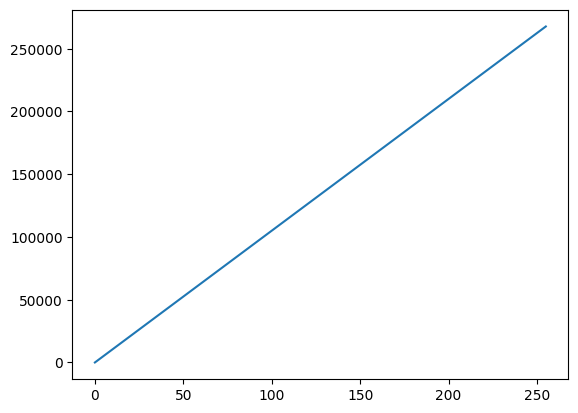

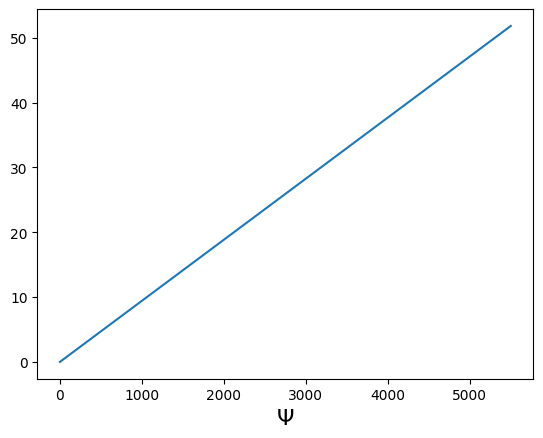

535411.4545726284 51.83627878423158


In [28]:
ring1.calc_beta2()
plt.plot(ring1.theta)
plt.show()
plt.plot(ring1.tau)
plt.xlabel(r"$\Psi$", fontsize=16)
plt.show()
P_t = np.max(ring1.tau)
P_x = 2*np.max(np.abs(ring1.theta))
print(P_x, P_t)

In [8]:
# # generate tau and t
T0, Theta0, u_init, v_init, T_lb, Theta_lb, T_ub, Theta_ub, T, Theta, seta_array, F = ring1.gen_tau_t_lhs(N0=200,Nb=200, Nf=40000)
print(T_lb.shape, Theta_lb.shape, T_ub.shape, Theta_ub.shape, T.shape, Theta.shape, seta_array.shape, F.shape, u_init.shape, v_init.shape)

(200, 1) (200, 1) (200, 1) (200, 1) (40000, 1) (40000, 1) (40000, 1) (40000, 1) (200, 1) (200, 1)


In [27]:
T_ = torch.Tensor(T).squeeze()
ids = torch.argsort(T_,dim=0)
T_splits = torch.split(T_[ids], len(T)//20)
T_ = torch.sort(T_,dim=0)[0]

torch.return_types.sort(
values=tensor([4.9848e-04, 2.0261e-03, 3.2749e-03,  ..., 5.1833e+01, 5.1834e+01,
        5.1835e+01]),
indices=tensor([ 8586,  8258, 14680,  ...,  5368, 34866, 17222]))

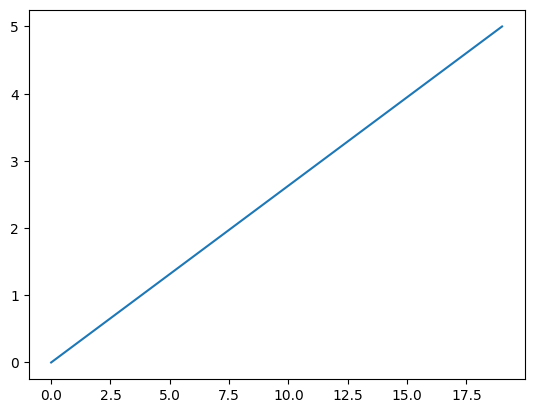

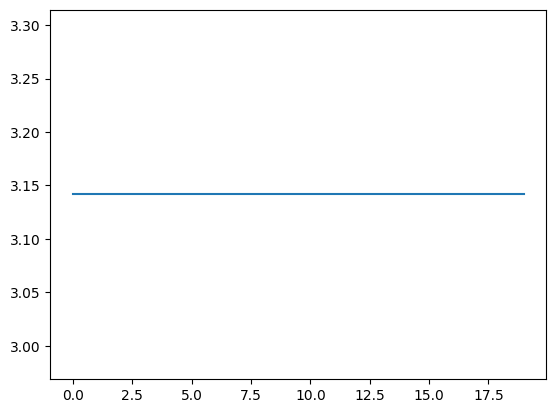

In [38]:
t = np.linspace(0,5,20)
theta = np.pi
t,x = np.meshgrid(t,theta)
plt.plot(t.flatten())
plt.show()
plt.plot(x.flatten())
plt.show()

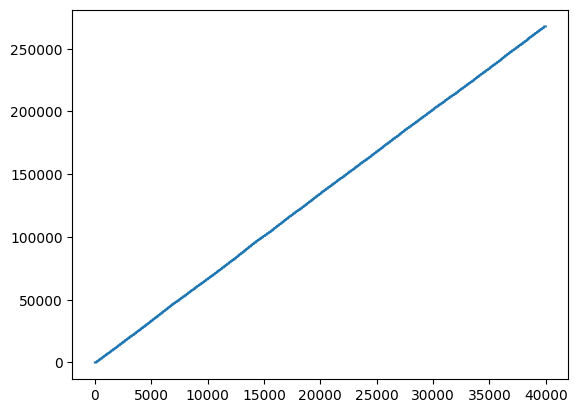

In [53]:
# ids = np.argsort(T.flatten())
# plt.plot(T[ids], Theta[ids])
# plt.show()
plt.plot(Theta)

In [14]:
def to_tensor_device(data_dict, device):
    """
    Convert arrays to tensors, set requires_grad=True for specific tensors, and move them to the specified device.

    Parameters:
    - data_dict (dict): Dictionary containing numpy arrays to be converted.
    - device (torch.device): The device to move the tensors to (CPU/GPU).

    Returns:
    - A dictionary with tensors moved to the specified device.
    """
    data_tensors = {}

    for key, value in data_dict.items():
        if isinstance(value, np.ndarray):
            # Set requires_grad=True for 'Theta_lb', 'Theta_ub', 'T', and 'Theta'
            if key in ['Theta_lb', 'Theta_ub', 'T_sampled', 'Theta_sampled']:
                data_tensors[key] = torch.tensor(value, dtype=torch.float32, requires_grad=True).to(device)
            else:
                data_tensors[key] = torch.tensor(value, dtype=torch.float32).to(device)
        else:
            data_tensors[key] = value  # If it's not an array, leave it as is

    return data_tensors


In [15]:
training_params = {
    'layers': [2, 256, 256, 256, 256, 2],  # Example architecture; modify as needed
    'mapping_size': 64, # Number of Fourier features,
    'use_skip_connections': False,
    'scale': [1,10,20],  # Scale for Fourier embedding
    'use_fourier_features': True,  # Set to True if you want to use Fourier features
    'use_rwf': True, # Set to True if you want to use ramdom weight factorization
    'alpha': 0.9, # avg parameter for lamdas
    'cal': False, # Set to True if you want to use causality aware loss
    'M': 15, # Number of time splits for causality aware loss
    'f':1000, # number of time steps to update lamdas
    'epsilons':[1e-2,1e-1,1,10,100]
}

In [16]:
Nf = 40000//training_params['M']
print('Number of collocation points:', Nf)
time_marching_data = ring1.gen_tau_t_lhs_time_march(Nf=Nf,M=training_params['M'])
time_marching_data.keys()

Number of collocation points: 2666
Generating data for time marching step 1/15
Generating data for time marching step 2/15
Generating data for time marching step 3/15
Generating data for time marching step 4/15
Generating data for time marching step 5/15
Generating data for time marching step 6/15
Generating data for time marching step 7/15
Generating data for time marching step 8/15
Generating data for time marching step 9/15
Generating data for time marching step 10/15
Generating data for time marching step 11/15
Generating data for time marching step 12/15
Generating data for time marching step 13/15
Generating data for time marching step 14/15
Generating data for time marching step 15/15


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

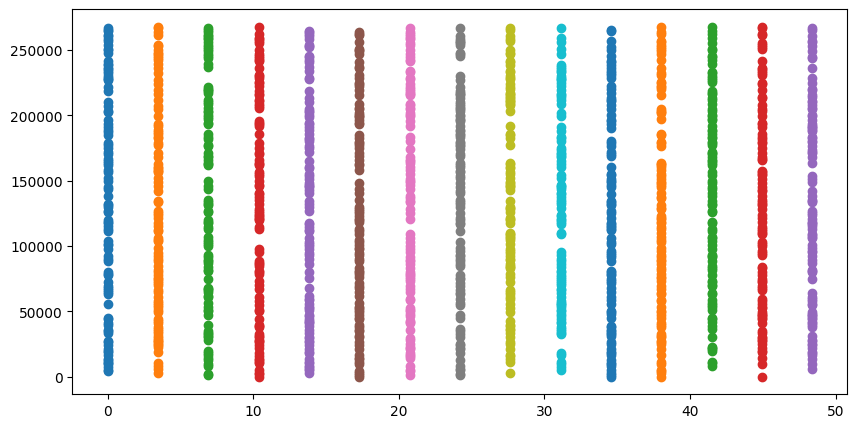

In [17]:
# plot T0 and Theta0 for all time marching steps in a single plot
plt.figure(figsize=(10, 5))
for i in range(training_params['M']):
  plt.scatter(time_marching_data[i]['T0'], time_marching_data[i]['Theta0'], label=f'Step {i+1}')

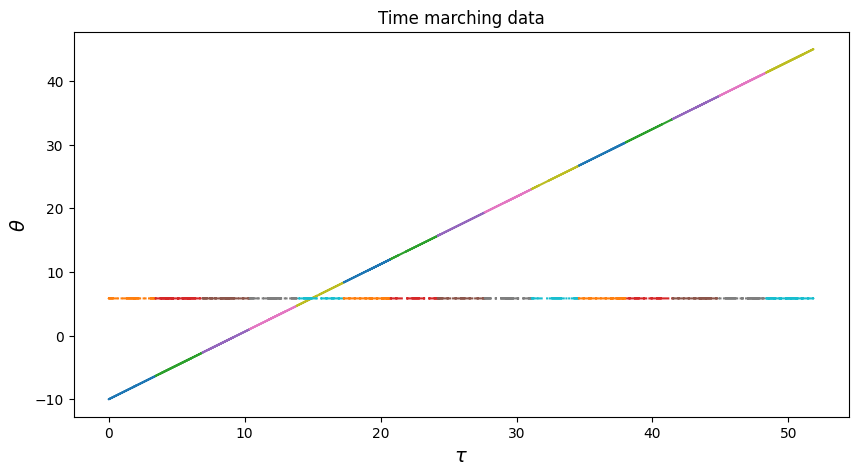

In [18]:
# plot seta array for each time marching step
plt.figure(figsize=(10, 5))
for i in range(training_params['M']):
  plt.plot(time_marching_data[i]['T_sampled'],time_marching_data[i]['seta_array'], label=f'Step {i+1}')
  # plot t_lb and theta_lb for each time marching step
  # plt.plot(time_marching_data[i]['T_lb'], time_marching_data[i]['Theta_lb'], label=f'Step {i+1}', linestyle='--')
  # plt.plot(time_marching_data[i]['T_ub'], time_marching_data[i]['Theta_ub'], label=f'Step {i+1}', linestyle=':')
  # plt.plot(time_marching_data[i]['T0'], time_marching_data[i]['Theta0'], label=f'Step {i+1}', linestyle='-')
  # # plot F for each time marching step
  plt.plot(time_marching_data[i]['T_sampled'], time_marching_data[i]['F'], label=f'Step {i+1}', linestyle='dashdot')
  # write del t , 2del t, 3 del t latex text for each time marching step
  # plt.text(time_marching_data[i]['T0'][0], -200000, fr'$\Delta t_{i}$', fontsize=14)
# plt.legend()
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel(r"$\theta$", fontsize=14)
plt.title("Time marching data")
plt.show()

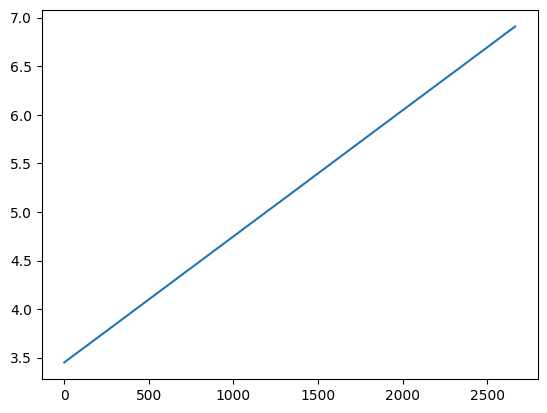

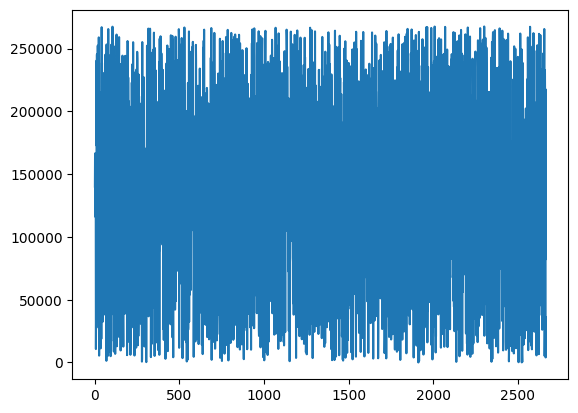

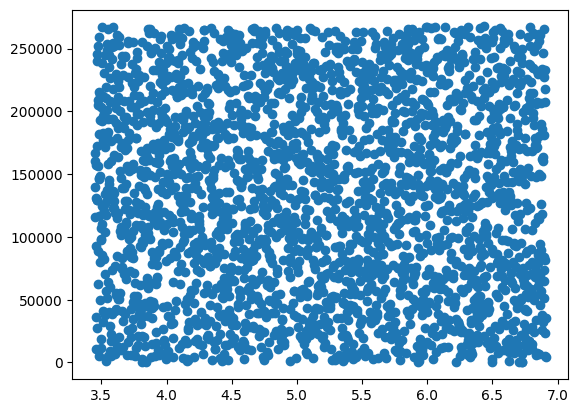

In [19]:
T0 = time_marching_data[1]['T_sampled']
Theta0 = time_marching_data[1]['Theta_sampled']
idx = np.argsort(T0.flatten())
plt.plot(T0.flatten()[idx])
plt.show()
plt.plot(Theta0.flatten()[idx])
plt.show()
plt.scatter(T0.flatten()[idx], Theta0.flatten()[idx])
plt.show()

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = PINN(layers=training_params['layers'],
               mapping_size=training_params['mapping_size'],
               scale=training_params['scale'],
               use_fourier_features=training_params['use_fourier_features'],
               use_rwf=training_params['use_rwf'],
               P_x=P_x,
               P_t=P_t,
               ).to(device)
optimizer = optim.AdamW(network.parameters(), lr=1e-3, weight_decay=1e-4)

print(network)

Modified Layers:  [768, 256, 256, 256, 2]
PINN(
  (fourier_embedding): FourierFeatureEmbedding()
  (layers): ModuleList(
    (0-3): 4 x RandomWeightFactorizationLayer()
  )
  (activation): Tanh()
)


In [21]:
# # Example configuration for 2D input
# input_dim = 2               # Number of input features (e.g., time and space)
# mapping_size = 4            # Number of Fourier features
# scale = [1,10,20]                 # Scale for Fourier embedding

# # Create the Fourier Feature Embedding model
# embedding = FourierFeatureEmbedding(mapping_size, scale, P_x, P_t)
# input_data = torch.cat([T_, Theta_], dim=1)
# # Forward pass through the embedding
# with torch.no_grad():
#     transformed_input1, transformed_input2 = embedding(input_data)

# # Plot original input (2D space)
# plt.figure(figsize=(10, 6))

# # Plot original input
# plt.subplot(1, 2, 1)
# plt.scatter(input_data[:, 0].cpu().detach().numpy(), input_data[:, 1].cpu().detach().numpy(), color='blue', s=1)
# plt.title("Original 2D Input")
# plt.xlabel("x")
# plt.ylabel("y")

# # Plot one of the transformed Fourier features
# plt.subplot(1, 2, 2)
# plt.scatter(input_data[:, 0].cpu().detach().numpy(), input_data[:, 1].cpu().detach().numpy(), c=transformed_input2[:, -1].cpu().detach().numpy(), cmap='viridis', s=1)
# plt.title("Transformed Fourier Feature (1st component)")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.colorbar(label="Fourier Feature Value")

# plt.tight_layout()
# plt.show()
# print(transformed_input1.shape, transformed_input2.shape)

In [22]:
# class StepLRWithMinLRScheduler:
#     def __init__(self, optimizer, step_size, gamma, min_lr):
#         self.scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
#         self.min_lr = min_lr

#     def step(self):
#         self.scheduler.step()
#         for param_group in self.scheduler.optimizer.param_groups:
#             param_group['lr'] = max(param_group['lr'], self.min_lr)

#     def get_last_lr(self):
#         # Returns the last learning rate(s) used by the wrapped scheduler
#         return [max(lr, self.min_lr) for lr in self.scheduler.get_last_lr()]

# # Set up the custom StepLR scheduler with a minimum learning rate
# min_lr = 5e-6
# scheduler = StepLRWithMinLRScheduler(optimizer, step_size=3000, gamma=0.5, min_lr=min_lr)

In [23]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=50)
# Function to reset the learning rate
def reset_learning_rate(optimizer, lr=1e-3):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # print reste lr
    print(f"Learning rate reset to {lr}")
# def lr_lambda(step):
#     decay_steps = 2000
#     decay_rate = 0.95
#     return decay_rate ** (step / decay_steps)

# # Set up the LambdaLR scheduler
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [24]:
T_val = ring1.tau#np.linspace(T.min(), T.max(), 1100)
Theta_val = ring1.theta#np.linspace(Theta.min(), Theta.max(), 441)
T_val, Theta_val = np.meshgrid(T_val, Theta_val)
T_val = T_val.flatten()[:, np.newaxis]
Theta_val = Theta_val.flatten()[:, np.newaxis]
T_val = torch.Tensor(T_val).to(device)
Theta_val = torch.Tensor(Theta_val).to(device)

def validate(network, T_val, Tau_val, T_lb=None, Tau_lb=None, T_ub=None, Tau_ub=None, T0=None, Tau0=None):
  network.eval()
  with torch.no_grad():
    e = network(torch.cat((T_val, Tau_val), dim=1)).cpu().detach().numpy()
  network.train()

  u = e[:,0:1]
  v = e[:,1:2]
  h = u + 1j*v
  h = h.reshape(len(ring1.modes), len(ring1.seta))
  # h2 = np.fliplr(h2)

  plt.figure(figsize=(14, 3))#figsize=(8, 10)
  plt.imshow(np.abs(h), cmap='jet', origin='lower', extent=[ring1.seta.min(), ring1.seta.max(), ring1.theta.min(), ring1.theta.max()], aspect='auto')
  plt.colorbar()
  plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  plt.ylabel(r"$\theta = (\varphi- D_1 t) \sqrt{\frac{\kappa}{2D_2}}$", fontsize=14)
  # plt.xlabel(r"$\tau = \kappa t$", fontsize=14)
  plt.xlabel(r"$\mathcal{\zeta} _0$", fontsize=14)
  if T_lb is not None and Tau_lb is not None:
    plt.scatter(T_lb, Tau_lb, c='k', marker='x', s=35)
  if T_ub is not None and Tau_ub is not None:
    plt.scatter(T_ub, Tau_ub, c='k', marker='x', s=35)
  if T0 is not None and Tau0 is not None:
    plt.scatter(T0, Tau0, c='m', marker='x', s=35)
  # plt.title('Predicted Field')
  plt.tight_layout()
  plt.title(r"$|\mathcal{\psi} (\tau, \theta)|$", fontsize=16, fontweight='bold')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

  fft_h = np.fft.fftshift(np.fft.ifft(h, axis=0), axes=0)
  abs_h = np.abs(fft_h)
  # abs_h = np.clip(abs_h,-100,0)
  plt.figure(figsize=(14, 3))
  if ring1.seta.max() == ring1.seta.min():
    cax=plt.imshow(abs_h, cmap='jet', origin='lower', aspect='auto')#, extent=[ring1.seta.min(), ring1.seta.max(), ring1.modes.min(), ring1.modes.max()]
  else:
    cax=plt.imshow(abs_h, cmap='jet', origin='lower', extent=[ring1.seta.min(), ring1.seta.max(), ring1.modes.min(), ring1.modes.max()], aspect='auto')
  cbar=plt.colorbar(cax)
  # cbar.set_label("dBm", rotation=90, labelpad=20)
  plt.ylabel(r"$\mu$", fontsize=14)
  plt.xlabel(r"$\mathcal{\zeta} _0$", fontsize=14)
  plt.tight_layout()
  plt.title(r"$\mathcal{F} \{ \mathcal{\psi} (\tau, \theta) \} $", fontsize=16, fontweight='bold')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()
  # return h2

In [25]:
# Save dictionary as a JSON file
def save_dict(name, data):
    json_file_path = name
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

# Load the JSON file back into a dictionary
def load_dict(name):
    with open(name, 'r') as json_file:
        loaded_data = json.load(json_file)
    return loaded_data

In [26]:
def plot_temporal_weights(w_i,x=None):
    plt.figure()
    if x is not None:
        plt.plot(x, w_i, 'o')
    else:
        plt.plot(np.arange(1,len(w_i)+1), w_i, 'o')
    plt.xlabel(r"$\mathcal{\zeta}_0$", fontsize=14)
    plt.ylabel(r"$\mathcal{W}_\mathcal{i}$", fontsize=14)
    # plt.xscale('log')
    plt.grid()
    plt.ylim(0,1.2)
    plt.show()
    plt.close()

Learning rate reset to 0.0001
Starting training with epsilon=1



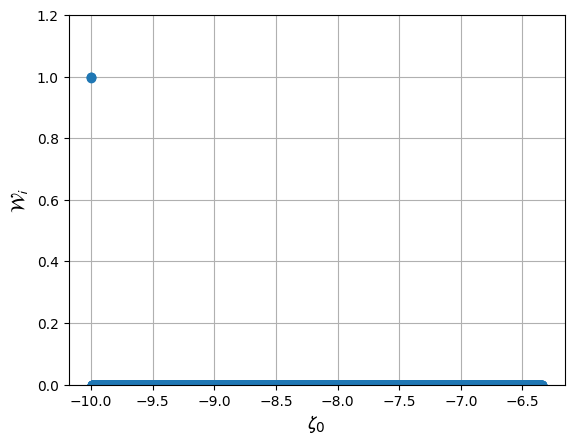

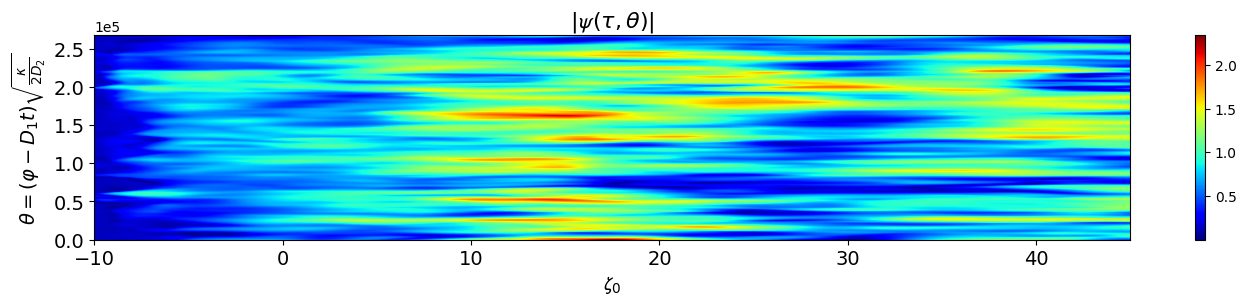

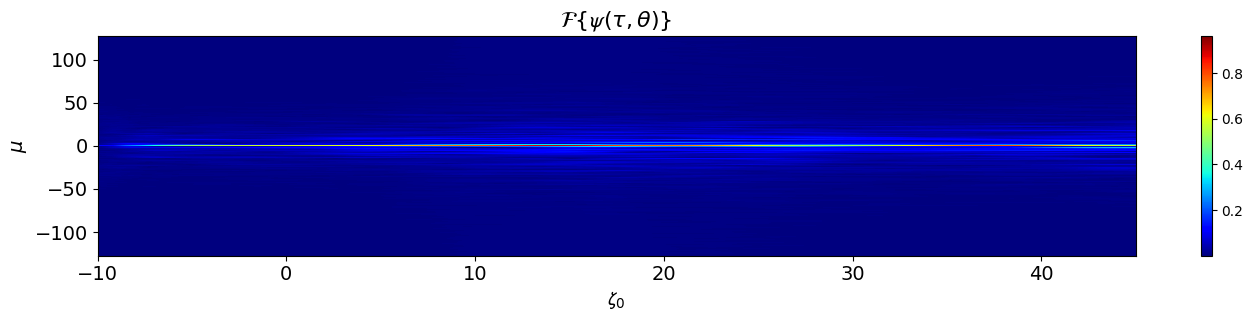

Epoch 0, Train Loss: 0.006081677973270416, Loss_b: 2.3782954485795926e-06, Loss_pde: 0.005856476258486509, Loss_init: 2.2282340523815947e-06
Current learning rate: 0.0001


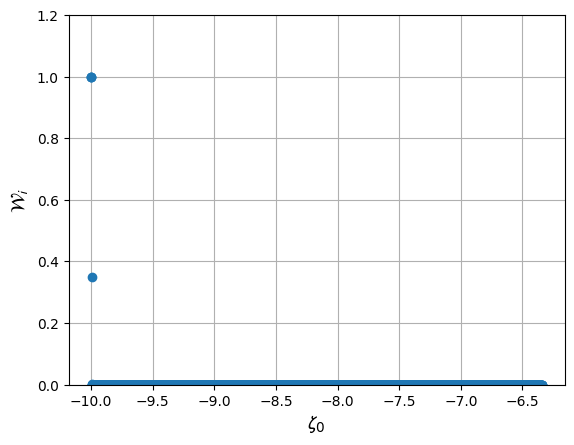

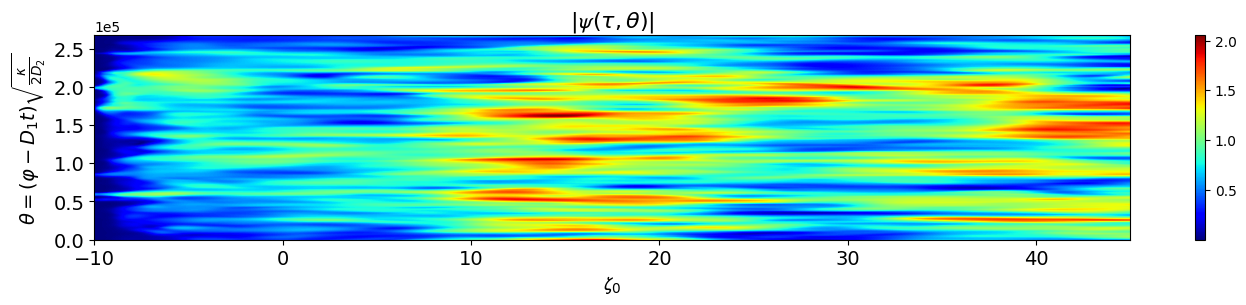

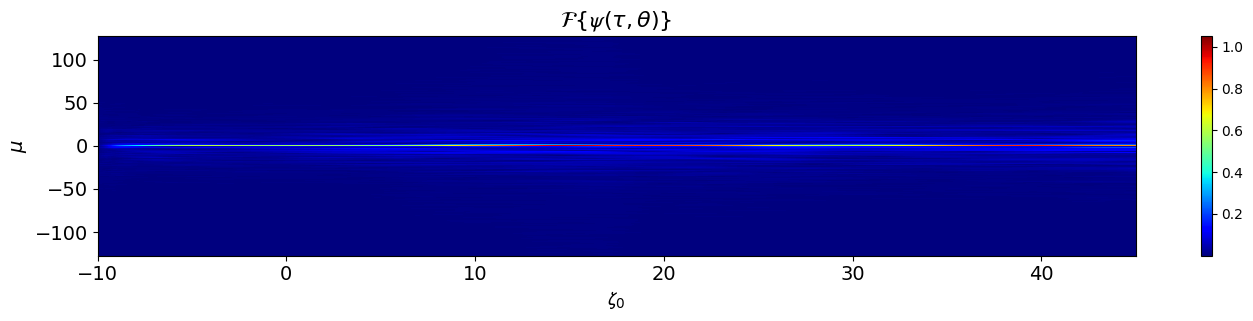

Epoch 1000, Train Loss: 0.0014734441647306085, Loss_b: 3.496058070595609e-06, Loss_pde: 0.001089619006961584, Loss_init: 3.803290837822715e-06
Current learning rate: 3.5184372088832037e-06


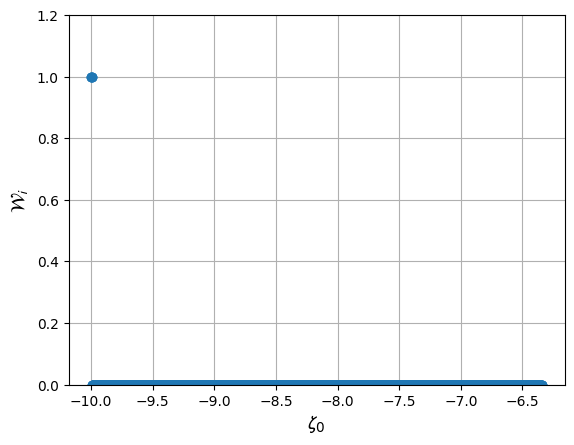

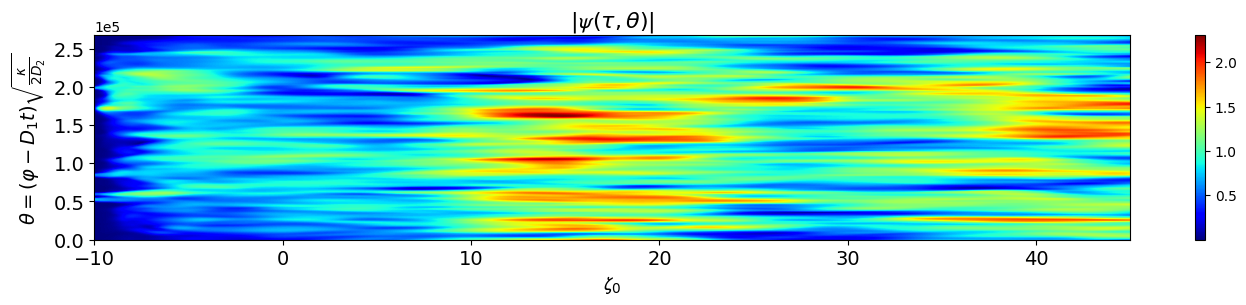

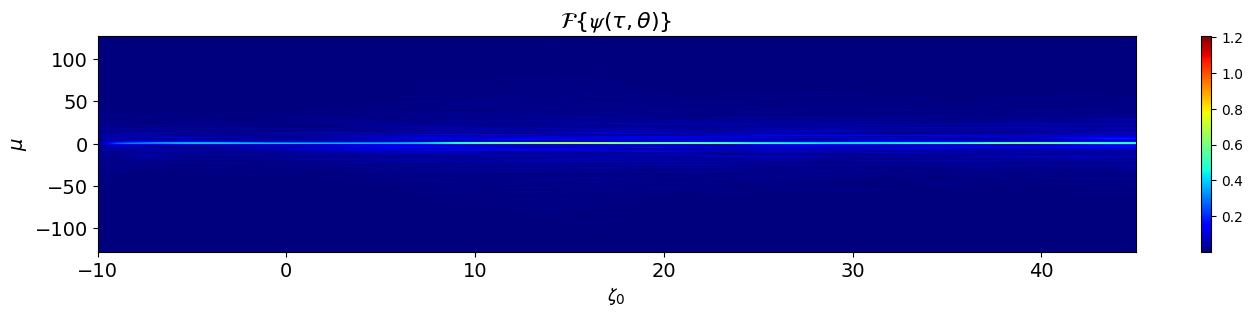

Epoch 2000, Train Loss: 0.0041565317660570145, Loss_b: 3.147259576508077e-06, Loss_pde: 0.003923173062503338, Loss_init: 2.302112989127636e-06
Current learning rate: 6.33825300114116e-08


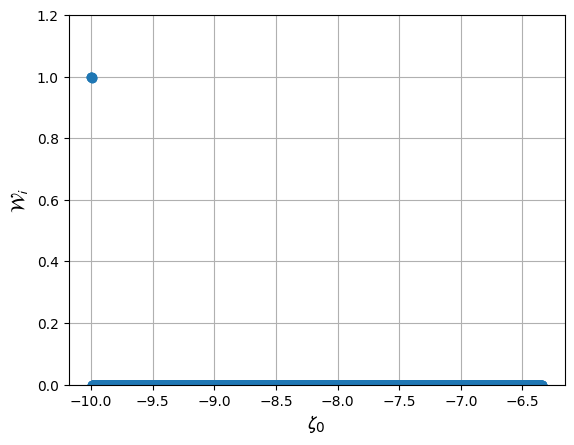

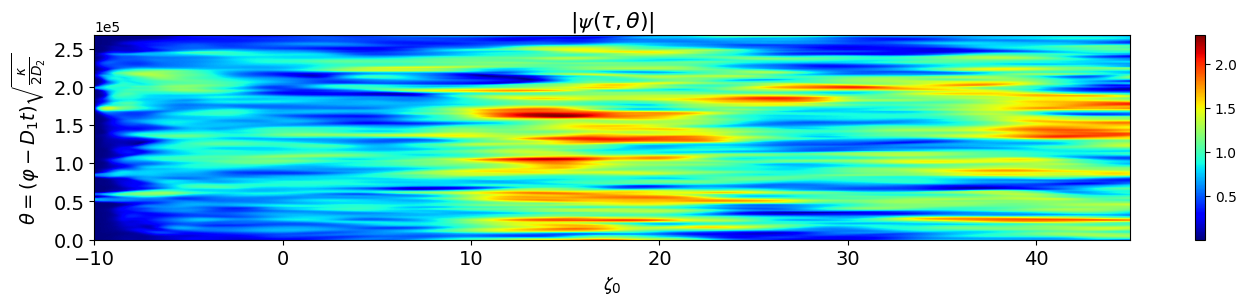

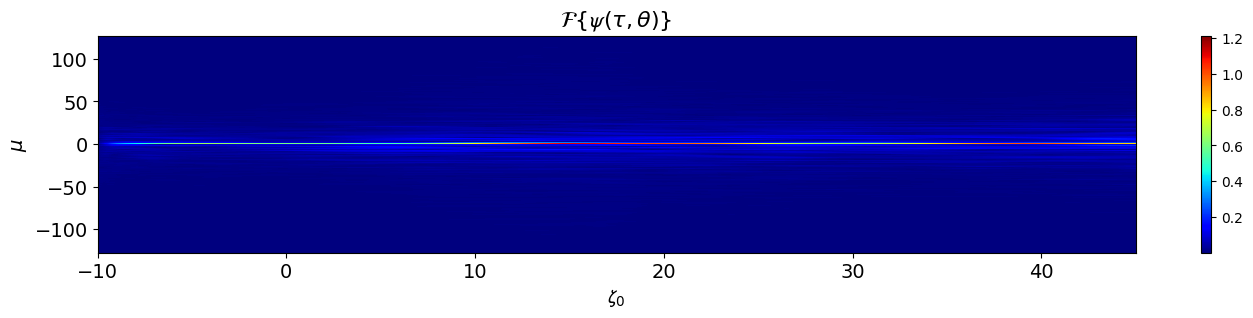

Epoch 3000, Train Loss: 0.0037929434329271317, Loss_b: 3.247017730245716e-06, Loss_pde: 0.0035807443782687187, Loss_init: 2.0895188299618894e-06
Current learning rate: 4.0564819207303424e-08


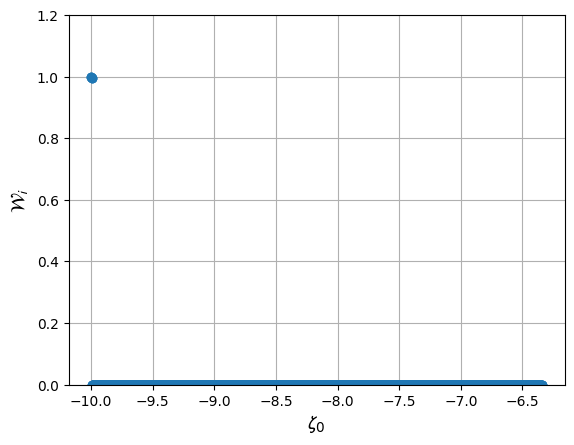

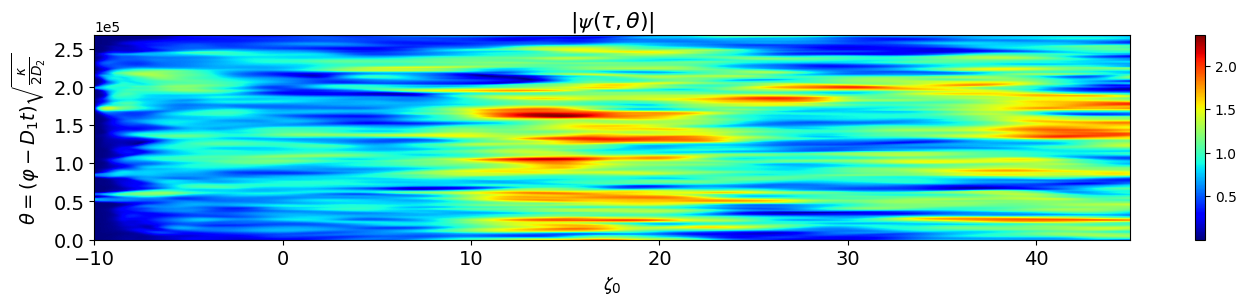

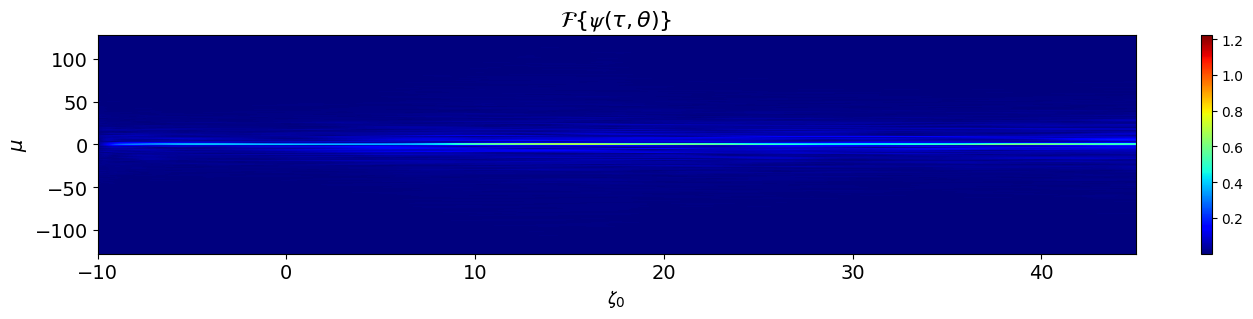

Epoch 4000, Train Loss: 0.0034558563493192196, Loss_b: 3.3077283205784624e-06, Loss_pde: 0.0032718051224946976, Loss_init: 1.8074333638651296e-06
Current learning rate: 4.0564819207303424e-08


In [ ]:
# def train_network_with_time_marching(network, prev_model, optimizer, scheduler, epochs, time_marching_data, training_params, device):
#     """
#     Train the network using time marching steps.

#     Parameters:
#     - network: The current neural network model.
#     - prev_model: The model from the previous time step (for time marching).
#     - optimizer: Optimizer for the training process.
#     - scheduler: Learning rate scheduler.
#     - epochs: Number of training epochs.
#     - time_marching_data: Dictionary containing the data for each time marching step.
#     - training_params: Dictionary containing hyperparameters like M, alpha, epsilon, etc.
#     - device: The device to perform the training on (CPU/GPU).
#     """
loss_history = []
lr_hist = []
# epochs = 50000  # Number of training epochs
with torch.no_grad():
    prev_model = copy.deepcopy(network)

M = training_params['M']  # Number of time marching steps

for t_step in range(M):
    print(f"Starting time marching step {t_step + 1}/{M}")

    lamda_b, lamda_pde, lamda_init = 1, 1, 100  # Initial lambda values for losses

    # Fetch data for the current time marching step
    data_batch1 = time_marching_data[t_step]

    # Convert data to tensors and move them to the specified device (CPU/GPU)
    data_batch = to_tensor_device(data_batch1, device)

    # Reset the initial condition for the first time marching step
    if t_step == 0:
        u_init_, v_init_ = data_batch['u_init'], data_batch['v_init']
    else:
        # For subsequent steps, use predictions from the previous network as initial condition
        with torch.no_grad():
            psi_init = prev_model(torch.cat([data_batch['T0'], data_batch['Theta0']], dim=1))
            u_init_, v_init_ = psi_init[:, 0:1], psi_init[:, 1:2]

    # Start training loop for the current time marching step
    epochs = 10000
    for epsilon in training_params['epsilons']:
        print(f"Starting training with epsilon={epsilon}\n")
        for epoch in range(epochs):
            # Extract relevant data from the batch
            T0_, Theta0_ = data_batch['T0'], data_batch['Theta0']
            T_lb_, Theta_lb_ = data_batch['T_lb'], data_batch['Theta_lb']
            T_ub_, Theta_ub_ = data_batch['T_ub'], data_batch['Theta_ub']
            T_, Theta_ = data_batch['T_sampled'], data_batch['Theta_sampled']
            seta_array_, F_ = data_batch['seta_array'], data_batch['F']

            # Zero the gradients
            optimizer.zero_grad()

            # Calculate losses (LLE loss function)
            loss_b, loss_pde, loss_init, lamda_b_new, lamda_pde_new, lamda_init_new,w_i,break_ = lle_loss(
                network, T0_, Theta0_, u_init_, v_init_, T_lb_, Theta_lb_, T_ub_, Theta_ub_, T_, Theta_, seta_array_, F_,
                True, epsilon=epsilon
            )

            if break_:
                print(f"Stopping training at epoch {epoch} due to the stopping condition.")
                break

            # Total loss
            # if epoch==0 and t_step>0:
            #   loss = lamda_b * loss_b + lamda_pde * loss_pde
            # else:
            loss = lamda_b * loss_b + lamda_pde * loss_pde + lamda_init * loss_init

            # Adaptive lambda adjustments every few epochs (e.g., every 'f' epochs)
            # if epoch % training_params['f'] == 0:
            #     lamda_b = training_params['alpha'] * lamda_b + (1 - training_params['alpha']) * lamda_b_new
            #     lamda_pde = training_params['alpha'] * lamda_pde + (1 - training_params['alpha']) * lamda_pde_new
            #     lamda_init = training_params['alpha'] * lamda_init + (1 - training_params['alpha']) * lamda_init_new
            #     lamda_init = np.clip(lamda_init, 0, 5e4)
            #     lamda_b = np.clip(lamda_b, 0, 5e4)
                # print(f'lambda_init: {lamda_init}, lambda_b: {lamda_b}, lambda_pde: {lamda_pde}')

            # Backpropagate the loss
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)

            # Optimize step
            optimizer.step()

            # Save loss and learning rate history
            loss_history.append([loss_b.item(), loss_pde.item(), loss_init.item()])
            lr_hist.append(scheduler.get_last_lr()[0])

            # Print validation and learning rate every 500 epochs
            if epoch % 1000 == 0:
                plot_temporal_weights(w_i, np.linspace(data_batch1['seta_array'].min(), data_batch1['seta_array'].max(), len(w_i)))
                validate(network, T_val, Theta_val)
                print(f"Epoch {epoch}, Train Loss: {loss.item()}, Loss_b: {loss_b.item()}, Loss_pde: {loss_pde.item()}, Loss_init: {loss_init.item()}")
                print(f"Current learning rate: {scheduler.get_last_lr()[0]}")

            # Step scheduler
            scheduler.step(loss.item())
    
        clear_output(wait=True)
        reset_learning_rate(optimizer, lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=50)
    # After training on the current time marching step, copy the current network to previous network
    print('Copying current network to previous network')
    with torch.no_grad():
        prev_model = copy.deepcopy(network)
    # prev_model.load_state_dict(network.state_dict())
    reset_learning_rate(optimizer, lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=50)
    # optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    print(f"Finished time marching step {t_step + 1}/{M}")    

In [26]:
name = 'saved_pinn_working_v10'
def save_model(network, name):
    torch.save(network.state_dict(), name+'.pth')
    save_dict(name+'.json', training_params)
    print('Model saved successfully ... ')
save_model(network, name)
def load_model(name):
    # load dict
    loaded_dict = load_dict(name+'.json')
    # load model
    model = PINN(layers=loaded_dict['layers'],
               mapping_size=loaded_dict['mapping_size'],
               scale=loaded_dict['scale'],
               use_fourier_features=loaded_dict['use_fourier_features'],
               use_rwf=loaded_dict['use_rwf'],
               P_x=P_x,
               P_t=P_t,
               ).to(device)
    model.load_state_dict(torch.load(name+'.pth'))
    model.eval()
    print('Model loaded successfully ... ')
    return model

In [ ]:
# Extract loss components and learning rates
loss_b = [row[0] for row in loss_history]
loss_pde = [row[1] for row in loss_history]
loss_init = [row[2] for row in loss_history]

# Create the double y-axis plot
fig, ax1 = plt.subplots()

# Plot losses on the first y-axis
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel(r"$ \mathcal{L}_\mathrm{nn}$", fontsize=14)
ax1.plot(loss_b, label=r"$\mathcal{L}_\mathrm{b}$", color='blue')
ax1.plot(loss_pde, label=r"$\mathcal{L}_\mathrm{pde}$", color='green')
ax1.plot(loss_init, label=r"$\mathcal{L}_\mathrm{init}$", color='red')
ax1.set_yscale('log')
ax1.legend(fontsize=14)
ax1.grid(True)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot learning rates on the second y-axis
ax2.set_ylabel('Learning Rate', fontsize=14)
ax2.plot(lr_hist, color='black', linestyle='--', label='lr')
ax2.legend(loc='center right',fontsize=14)
ax2.set_yscale('log')
# ax2.grid(True)

# Set the title and labels
plt.title('Loss and Learning Rate vs. Epochs')
plt.tight_layout()
plt.savefig(name+'_learn'+'.png')
plt.show()

In [30]:
# training_params = load_dict('saved_pinn_working_v10.json')
# network2 = PINN(layers=training_params['layers'],
#                mapping_size=training_params['mapping_size'],
#                scale=training_params['scale'],
#                use_fourier_features=training_params['use_fourier_features'],
#                use_rwf=training_params['use_rwf'],
#                P_x=P_x,
#                P_t=P_t,
#                ).to(device)
# network2.load_state_dict(torch.load('saved_pinn_working_v10.pth', weights_only=False))

In [ ]:
validate(network, T_val, Theta_val)

In [35]:
h_pred2, h = predict_field(network, T_val, Theta_val, (len(ring1.modes),len(ring1.seta)))
# savemat('saved_pinn_working_v4_field.mat', {'h':h})

In [ ]:
# surf plot of the field h_pred\
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
X, Y = Theta_val.cpu().numpy().reshape(len(ring1.modes),len(ring1.seta)), T_val.cpu().numpy().reshape(len(ring1.modes),len(ring1.seta))
# X,Y = ring1.seta_array.reshape(len(ring1.modes),len(ring1.seta)), Theta_val.reshape(len(ring1.modes),len(ring1.seta))
ax.plot_surface(X, Y, h_pred2, cmap='jet')
ax.set_xlabel(r"$\theta$", fontsize=14)
ax.set_ylabel(r"$\tau$", fontsize=14)
# ax.set_
# ax.view_init(elev=30, azim=30)
# plt.tight_layout()
plt.show()

In [ ]:
plt.plot(ring1.seta,h_pred2.sum(axis=0))
plt.show()

In [38]:
def pad_array_center(arr, target_N=4096):
  N, M = arr.shape  # Original dimensions of the array

  if N >= target_N:
      raise ValueError("N must be smaller than the target size (4096).")

  # Create a new array of zeros with the desired shape (4096, M)
  padded_array = np.zeros((target_N, M), dtype=np.complex128)

  # Calculate the start and end indices to center the original array
  start_idx = (target_N - N) // 2
  end_idx = start_idx + N

  # Place the original array in the center of the padded array
  padded_array[start_idx:end_idx, :] = arr

  return padded_array

In [ ]:
idx = 4000
t = np.linspace(-1/(ring1.FSR/2),1/(ring1.FSR/2), ring1.N)*1e12
plt.plot(t,h_pred2[:,idx])
plt.grid()
plt.xlabel('Time (ps)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.show()

h_padded = pad_array_center(h_pred2)
fft_p = np.fft.fftshift(np.fft.fft(h_padded[:, idx]))
abs_b =10*np.log10(np.abs(fft_p)) + 30
# abs_b = np.clip(abs_b,30,55)
# abs_p = np.clip(abs_b,-100,0)
f = np.linspace(ring1.freq_array.min(), ring1.freq_array.max(),4096)/1e12
plt.grid()
plt.plot(f,abs_b)
# plt.yscale('log')
plt.ylabel('Amplitude (dBm)',fontsize=14)
plt.xlabel('Freq (THz)',fontsize=14)
plt.show()

In [ ]:
plt.imshow(np.real(h), cmap='jet', origin='lower', extent=[T.min(), T.max(), Theta.min(), Theta.max()], aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(np.imag(h), cmap='jet', origin='lower', extent=[T.min(), T.max(), Theta.min(), Theta.max()], aspect='auto')
plt.colorbar()
plt.show()

In [41]:
tau = 30
theta = ring1.theta
Tau_val1, Theta_val1 = np.meshgrid(tau, theta)
Tau_val1 = Tau_val1.flatten()[:, np.newaxis]
Theta_val1 = Theta_val1.flatten()[:, np.newaxis]
Tau_val1 = torch.Tensor(Tau_val1).to(device)
Theta_val1 = torch.Tensor(Theta_val1).to(device)
h_pred2, h = predict_field(network, Tau_val1, Theta_val1, (len(ring1.modes),1))
